## Research: how to do *differential* argmax/argmin

Consolidating findings from previous book in this series here.

**Progress 9.20.2020:** Gumbel Softmax is looking less promising and 

**Notes:**
https://discuss.pytorch.org/t/differentiable-argmax/33020/106

**Talk Thru:** To get a NN to estimate the "top-left-point" function, we'll want to add argmax/argmin style functions onto the network which will allows us to predict the "top-most" / "left-most" point, etc. 

In this first stage, in *research-custom-nnmodules-1.ipynb*, we looked at building our own custom model pytorch style. This allows us to use more than simply the nn.builtins in Sequential, and possibily add our own custom layer function.

One issue to account for is that each layer within the netork must be differentiable with a forward and backward method that autograd can use.

To accomplish that, we looked at several methods of doing this:
 
 - Using `nn.MaxPool1d(return_indices=True)` which will simulate argmax when using the returned indices. Since MaxPool1d only work over 1-dimension, we transposed the image, pooled again, concatenating the result for each row, with result for each col. The problem with this method is that the indices go not have a `grad` (but the other tensor with the pooling process, the max-values in this case does have a `grad`).
 
 
 - Below, we explore using `gumbel_softmax` perhaps with a pre-processing of rectification somewhere.
 
 
 - Another option to consider is doing a straight-up non-differential argmax and using that as an "embedding" layer which may work without a chain of grad's.



### Setup - imported from previous books

In [1]:
import os, sys
import copy as copyroot
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

from fastai2.basics import *
from fastai2.vision.all import *

from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

from module.mnist_helpers import build_df, eda_fig_1
from module.mnist_helpers import img_pt_plot, train_history_dualplot

path = untar_data(URLs.MNIST_TINY)
df = build_df(path)
df.head(2)

y_names = [
    'point_topleft_x', 
    'point_topleft_y',
    'point_center_x',
    'point_center_y'
    ]

db =   DataBlock(blocks=(ImageBlock(cls=PILImageBW), 
                         PointBlock), 
                splitter=RandomSplitter(seed=0),
                get_x=ColReader('fn', pref=path),
                )

db_1_topleft = copyroot.deepcopy(db)
db_1_center  = copyroot.deepcopy(db)
db_2         = copyroot.deepcopy(db)

def set_get_y(db, cr):
    db.get_y = cr
    db.getters[db.n_inp:] = L(db.get_y)

set_get_y( db_1_topleft, ColReader(y_names[:2]) )
set_get_y( db_1_center,  ColReader(y_names[2:]) )
set_get_y( db_2,         ColReader(y_names) )

dl_1_topleft = db_1_topleft.dataloaders(df)
dl_1_center  = db_1_center.dataloaders(df)
dl_2         = db_2.dataloaders(df)

# remake a datablock with BW-style images

y_names = [
    'point_topleft_x', 
    'point_topleft_y',
    'point_center_x',
    'point_center_y'
    ]

dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), PointBlock), 
                  splitter=RandomSplitter(),
                   get_x=ColReader('fn', pref=path),
                   get_y=ColReader(y_names[2:]),
                  )

dls = dblock.dataloaders(df)

x, y = dls.one_batch()

x.shape

x_2 = x[:2]
x_2.shape

torch.Size([2, 1, 28, 28])

##### The example we'll consider

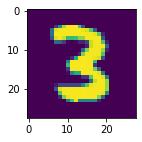

In [7]:
plt.figure(figsize=(2,2)); plt.imshow(x_2[0].squeeze(0));

### Examine `gumbel_softmax`
This is nice because it gives us a differential argmax-like via a built-in.

Problems to solve:
 
 - when there a full rows and columns of zeros, an arbitrary index is chosen.
 
 
 - we don't want the true argmax, but the first/last element that is non-zero, meaning we want to consider activation =0 vs. >0.
 
    - perhaps we can do argmins on rotated/mirrored image to find the last zero on the left and first zero on the right.
    
    - or we can do rectification with a hard sigmoid (and something else to adjust for the small differences in >0).

In [14]:
def gsm(t, dim=-1, tau=1, eps=1e-10):
    return torch.nn.functional.gumbel_softmax(
                                    t, 
                                    tau=tau,
                                    eps=eps,
                                    hard=True,
                                    dim=dim)

##### Demonstrate softmax across dimension {0, 1}

Dim0 - across columns

Dim1 - across rows

In [78]:
a0 = torch.tensor([[0.,10.,3.], [-2.,6.,8.], [-4.,3.,2.]], 
                  dtype=torch.float,
                  requires_grad=True)
a0

tensor([[ 0., 10.,  3.],
        [-2.,  6.,  8.],
        [-4.,  3.,  2.]], requires_grad=True)

In [72]:
gsm(a0, dim=0)

tensor([[1., 1., 0.],
        [0., 0., 1.],
        [0., 0., 0.]], grad_fn=<AddBackward0>)

In [93]:
gsm(a0, dim=1)

tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], grad_fn=<AddBackward0>)

Note: the above calc on `dim=1` does not always come out the smae way. Sometimes it is "wrong(?)" for the third row marking 2 as greater than 3?

-------

##### Arbitrary / "Non-deterministic" results for all zeros
Below we see that column 1,2,1 are chosen but these are arbitrary selection. It would be better if each time the function would chose the first or the last zero-value.

We also show that the result changes when the same calc is performed within a for-loop multiple times.

In [16]:
a1 = torch.tensor([[0.,0.,0.], [0.,0.,0.], [0.,0.,0.]], 
                  dtype=torch.float,
                  requires_grad=True)
a1

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], requires_grad=True)

In [15]:
gsm(a1)

tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], grad_fn=<AddBackward0>)

In [37]:
out1 = gsm(a1)
for trial in range(10):
    out2 = gsm(a1)
    if (out1 != out2).any():
        print(f'diff results on trial {trial}!\n{out1}\nvs.\n{out2}')
        break

diff results on trial 0!
tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]], grad_fn=<AddBackward0>)
vs.
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], grad_fn=<AddBackward0>)


In [ ]:
torch.nn.functional.gumbel_softmax()

### Examine some rectification procedures: